In [16]:

import pandas as pd
import numpy as np
import os


raw_data = pd.read_csv('data/Crash_Data.csv')

#print(data.describe())
print(raw_data.columns)



Index(['X', 'Y', 'OBJECTID', 'DOCUMENT_NBR', 'CRASH_YEAR', 'CRASH_DT',
       'CRASH_MILITARY_TM', 'CRASH_SEVERITY', 'K_PEOPLE', 'A_PEOPLE',
       'B_PEOPLE', 'C_PEOPLE', 'PERSONS_INJURED', 'PEDESTRIANS_KILLED',
       'PEDESTRIANS_INJURED', 'VEH_COUNT', 'COLLISION_TYPE',
       'WEATHER_CONDITION', 'LIGHT_CONDITION', 'ROADWAY_SURFACE_COND',
       'RELATION_TO_ROADWAY', 'ROADWAY_ALIGNMENT', 'ROADWAY_SURFACE_TYPE',
       'ROADWAY_DEFECT', 'ROADWAY_DESCRIPTION', 'INTERSECTION_TYPE',
       'TRAFFIC_CONTROL_TYPE', 'TRFC_CTRL_STATUS_TYPE', 'WORK_ZONE_RELATED',
       'WORK_ZONE_LOCATION', 'WORK_ZONE_TYPE', 'SCHOOL_ZONE',
       'FIRST_HARMFUL_EVENT', 'FIRST_HARMFUL_EVENT_LOC', 'ALCOHOL_NOTALCOHOL',
       'ANIMAL', 'BELTED_UNBELTED', 'BIKE_NONBIKE', 'DISTRACTED_NOTDISTRACTED',
       'DROWSY_NOTDROWSY', 'DRUG_NODRUG', 'GR_NOGR', 'HITRUN_NOT_HITRUN',
       'LGTRUCK_NONLGTRUCK', 'MOTOR_NONMOTOR', 'PED_NONPED', 'SPEED_NOTSPEED',
       'SPEED_DIFF_MAX', 'RD_TYPE', 'INTERSECTION_ANALYSIS',

In [ ]:
columns_list = [
    'RNS_MP', 
    'PLAN_DISTRICT', 
    'MPO_NAME', 
    'NODE', 
    'OFFSET', 
    'VSP', 
    'JURIS_CODE', 
    'NIGHT', 
    'RD_TYPE',
    'DOCUMENT_NBR', 
    'OBJECTID', 
    'CRASH_YEAR'
]

data = raw_data.drop(columns=columns_list)
data['month'] = pd.to_datetime(data['CRASH_DT']).dt.strftime('%B')
data = data.drop(columns=['CRASH_DT'])

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
numerical_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.select_dtypes(include=['object']).columns

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_columns),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ])

data_prepared = full_pipeline.fit_transform(data)

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_prepared)
labels = kmeans.predict(data_prepared)
centers = kmeans.cluster_centers_



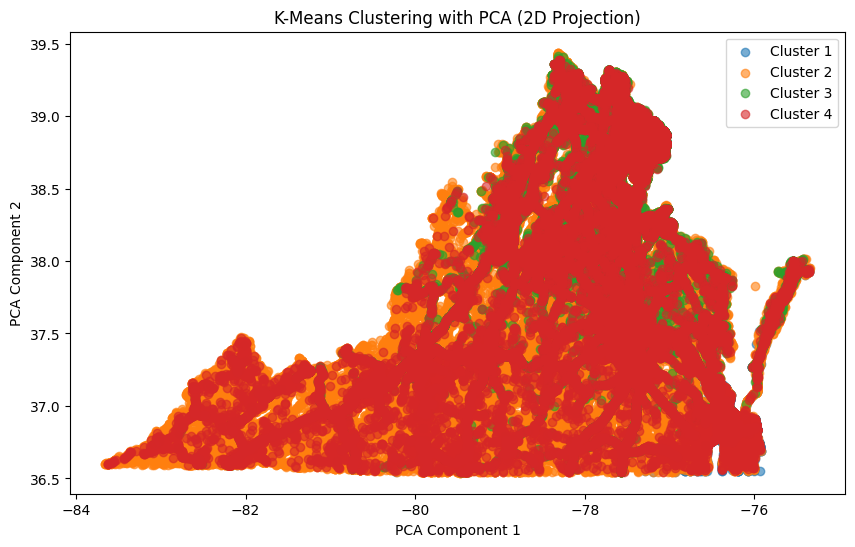

In [50]:

from sklearn.decomposition import PCA

geo_columns = ['X', 'Y']

# Extract longitude and latitude before transformations
geo_data = data[geo_columns].values


pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_prepared)

# Plot clusters
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
for i in range(4):
    plt.scatter(geo_data[labels == i, 0], geo_data[labels == i, 1], label=f'Cluster {i + 1}', alpha=0.6)


# # Plot centroids
# centers_2d = pca.transform(centers)
# plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('K-Means Clustering with PCA (2D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
